# MLP on Simulated ORFs  
Start with ORF_MLP_118 which had the simulator bug fix.  
Evaluate MLP with wide,deep network.  
Train on copious simulated data.  
Use uniform but longer RNA lengths: 1500   
Run on Alien.
79% accuracy.

In [1]:
import time
def show_time():
    t = time.time()
    print(time.strftime('%Y-%m-%d %H:%M:%S %Z', time.localtime(t)))
show_time()

2021-08-16 13:32:02 EDT


In [2]:
PC_TRAINS=50000
NC_TRAINS=50000
PC_TESTS=5000
NC_TESTS=5000   
RNA_LEN=1500  
MAX_K = 3 
INPUT_SHAPE=(None,84)  # 4^3 + 4^2 + 4^1
NEURONS=128
DROP_RATE=0.30
EPOCHS=200
SPLITS=3
FOLDS=3   # make this 5 for serious testing

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
 
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

from keras.models import Sequential
from keras.layers import Dense,Embedding,Dropout
from keras.layers import Flatten,TimeDistributed
from keras.losses import BinaryCrossentropy
from keras.callbacks import ModelCheckpoint
from keras.models import load_model

2021-08-16 13:32:03.301763: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


In [4]:
import sys
IN_COLAB = False
try:
    from google.colab import drive
    IN_COLAB = True
except:
    pass
if IN_COLAB:
    print("On Google CoLab, mount cloud-local file, get our code from GitHub.")
    PATH='/content/drive/'
    #drive.mount(PATH,force_remount=True)  # hardly ever need this
    drive.mount(PATH)    # Google will require login credentials
    DATAPATH=PATH+'My Drive/data/'  # must end in "/"
    import requests
    r = requests.get('https://raw.githubusercontent.com/ShepherdCode/Soars2021/master/SimTools/RNA_describe.py')
    with open('RNA_describe.py', 'w') as f:
        f.write(r.text)  
    from RNA_describe import ORF_counter
    r = requests.get('https://raw.githubusercontent.com/ShepherdCode/Soars2021/master/SimTools/GenCodeTools.py')
    with open('GenCodeTools.py', 'w') as f:
        f.write(r.text)  
    from GenCodeTools import GenCodeLoader
    r = requests.get('https://raw.githubusercontent.com/ShepherdCode/Soars2021/master/SimTools/KmerTools.py')
    with open('KmerTools.py', 'w') as f:
        f.write(r.text)  
    from KmerTools import KmerTools
    r = requests.get('https://raw.githubusercontent.com/ShepherdCode/Soars2021/master/SimTools/DataPrep.py')
    with open('DataPrep.py', 'w') as f:
        f.write(r.text)  
    from DataPrep import DataPrep
else:
        print("CoLab not working. On my PC, use relative paths.")
        DATAPATH='data/'  # must end in "/"
        sys.path.append("..") # append parent dir in order to use sibling dirs
        from SimTools.RNA_describe import ORF_counter
        from SimTools.GenCodeTools import GenCodeLoader
        from SimTools.KmerTools import KmerTools
        from SimTools.DataPrep import DataPrep
BESTMODELPATH=DATAPATH+"BestModel"  
LASTMODELPATH=DATAPATH+"LastModel"  

CoLab not working. On my PC, use relative paths.


## Data Load


In [5]:
show_time()
def make_generators(seq_len):
    pcgen = Collection_Generator()  
    pcgen.get_len_oracle().set_mean(seq_len)
    pcgen.set_seq_oracle(Transcript_Oracle())
    ncgen = Collection_Generator()  
    ncgen.get_len_oracle().set_mean(seq_len)
    return pcgen,ncgen

pc_sim,nc_sim = make_generators(RNA_LEN)
pc_all = pc_sim.get_sequences(PC_TRAINS+PC_TESTS)
nc_all = nc_sim.get_sequences(NC_TRAINS+NC_TESTS)
print("Generated",len(pc_all),"PC seqs")
print("Generated",len(nc_all),"NC seqs")
pc_sim=None
nc_sim=None

2021-08-16 13:32:03 EDT
Generated 55000 PC seqs
Generated 55000 NC seqs


In [6]:
print("Simulated sequence characteristics:")
oc = ORF_counter()
print("PC seqs")
oc.describe_sequences(pc_all)
print("NC seqs")
oc.describe_sequences(nc_all)
oc=None
show_time()

Simulated sequence characteristics:
PC seqs
Average RNA length: 1500.0
Average ORF length: 1011.2168727272727
NC seqs
Average RNA length: 1500.0
Average ORF length: 208.37318181818182
2021-08-16 13:32:35 EDT


## Data Prep

In [7]:
dp = DataPrep()
Xseq,y=dp.combine_pos_and_neg(pc_all,nc_all)
nc_all=None
pc_all=None
nc_all=None
print("The first few shuffled labels:")
print(y[:30])
show_time()

The first few shuffled labels:
[0 1 1 0 0 1 0 1 1 1 0 1 1 1 0 1 0 0 0 1 0 0 0 0 1 1 0 0 0 0]
2021-08-16 13:32:36 EDT


In [8]:
Xfrq=KmerTools.seqs_to_kmer_freqs(Xseq,MAX_K)
Xseq = None
y=np.asarray(y)
show_time()

{'A': 0.24733333333333332, 'C': 0.244, 'G': 0.24933333333333332, 'T': 0.25933333333333336, 'AA': 0.056037358238825885, 'AC': 0.054036024016010674, 'AG': 0.06804536357571714, 'AT': 0.06937958639092728, 'CA': 0.058038692461641096, 'CC': 0.06470980653769179, 'CG': 0.06337558372248166, 'CT': 0.057371581054036024, 'GA': 0.06337558372248166, 'GC': 0.057371581054036024, 'GG': 0.06470980653769179, 'GT': 0.06404269513008673, 'TA': 0.07004669779853236, 'TC': 0.06737825216811208, 'TG': 0.0533689126084056, 'TT': 0.06871247498332221, 'AAA': 0.014018691588785047, 'AAC': 0.015353805073431242, 'AAG': 0.01602136181575434, 'AAT': 0.010680907877169559, 'ACA': 0.011348464619492658, 'ACC': 0.014686248331108143, 'ACG': 0.014018691588785047, 'ACT': 0.014018691588785047, 'AGA': 0.016688918558077435, 'AGC': 0.01335113484646195, 'AGG': 0.02069425901201602, 'AGT': 0.017356475300400534, 'ATA': 0.01602136181575434, 'ATC': 0.018024032042723633, 'ATG': 0.01335113484646195, 'ATT': 0.022029372496662217, 'CAA': 0.01335

In [9]:
# Assume X and y were shuffled.
train_size=PC_TRAINS+NC_TRAINS
X_train=Xfrq[:train_size] 
X_test=Xfrq[train_size:]
y_train=y[:train_size] 
y_test=y[train_size:]
print("Training set size=",len(X_train),"=",len(y_train))
print("Reserved test set size=",len(X_test),"=",len(y_test))
Xfrq=None
y=None
show_time()

Training set size= 100000 = 100000
Reserved test set size= 10000 = 10000
2021-08-16 13:33:07 EDT


## Neural network

In [10]:
def make_DNN():
    dt=np.float32
    print("make_DNN")
    print("input shape:",INPUT_SHAPE)
    dnn = Sequential()
    dnn.add(Dense(NEURONS,activation="sigmoid",dtype=dt))  
    dnn.add(Dropout(DROP_RATE))
    dnn.add(Dense(NEURONS,activation="sigmoid",dtype=dt)) 
    dnn.add(Dropout(DROP_RATE))
    dnn.add(Dense(NEURONS,activation="sigmoid",dtype=dt)) 
    dnn.add(Dropout(DROP_RATE))
    dnn.add(Dense(1,activation="sigmoid",dtype=dt))   
    dnn.compile(optimizer='adam',    
                loss=BinaryCrossentropy(from_logits=False),
                metrics=['accuracy'])   # add to default metrics=loss
    dnn.build(input_shape=INPUT_SHAPE) 
    return dnn
model = make_DNN()
print(model.summary())

make_DNN
input shape: (None, 84)
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 128)               10880     
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               16512     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               16512     
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_3 (Dense)        

2021-08-16 13:33:07.464718: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2021-08-16 13:33:07.530202: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-08-16 13:33:07.531925: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:02:00.0 name: NVIDIA GeForce RTX 2080 Ti computeCapability: 7.5
coreClock: 1.545GHz coreCount: 68 deviceMemorySize: 10.75GiB deviceMemoryBandwidth: 573.69GiB/s
2021-08-16 13:33:07.531990: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2021-08-16 13:33:07.537816: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2021-08-16 13:33:07.537921: I tensorflow/stream_executor

In [11]:
def do_cross_validation(X,y):
    cv_scores = []
    fold=0
    mycallbacks = [ModelCheckpoint(
        filepath=BESTMODELPATH, save_best_only=True, 
        monitor='val_accuracy', mode='max')]   
    # When shuffle=True, the valid indices are a random subset.
    # No need to shuffle here assuming data was shuffled above.
    splitter = KFold(n_splits=SPLITS,shuffle=False) 
    model = None
    for train_index,valid_index in splitter.split(X):
        if fold < FOLDS:
            fold += 1
            X_train=X[train_index] # inputs for training
            y_train=y[train_index] # labels for training
            X_valid=X[valid_index] # inputs for validation
            y_valid=y[valid_index] # labels for validation
            print("MODEL")
            # Call constructor on each CV. Else, continually improves the same model.
            model = model = make_DNN()
            print("FIT")  # model.fit() implements learning
            start_time=time.time()
            history=model.fit(X_train, y_train, 
                    epochs=EPOCHS, 
                    verbose=1,  # ascii art while learning
                    callbacks=mycallbacks,   # called at end of each epoch
                    validation_data=(X_valid,y_valid))
            end_time=time.time()
            elapsed_time=(end_time-start_time)                        
            print("Fold %d, %d epochs, %d sec"%(fold,EPOCHS,elapsed_time))
            # print(history.history.keys())  # all these keys will be shown in figure
            pd.DataFrame(history.history).plot(figsize=(8,5))
            plt.grid(True)
            plt.gca().set_ylim(0,1) # any losses > 1 will be off the scale
            plt.show()
    return model  # parameters at end of training

2021-08-16 13:33:08 EDT
MODEL
make_DNN
input shape: (None, 84)
FIT
Epoch 1/200


2021-08-16 13:33:08.149790: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2021-08-16 13:33:08.169796: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 2496000000 Hz
2021-08-16 13:33:14.543444: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11


 157/2084 [=>............................] - ETA: 1s - loss: 0.7223 - accuracy: 0.4991 

2021-08-16 13:33:14.863564: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublasLt.so.11


2084/2084 [==============================] - 10s 1ms/step - loss: 0.7041 - accuracy: 0.5023 - val_loss: 0.6933 - val_accuracy: 0.4984


2021-08-16 13:33:18.077263: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: data/BestModel/assets
Epoch 2/200
2084/2084 [==============================] - 2s 1ms/step - loss: 0.6935 - accuracy: 0.4992 - val_loss: 0.6932 - val_accuracy: 0.4984
Epoch 3/200
2084/2084 [==============================] - 2s 1ms/step - loss: 0.6933 - accuracy: 0.4981 - val_loss: 0.6931 - val_accuracy: 0.5016
INFO:tensorflow:Assets written to: data/BestModel/assets
Epoch 4/200
2084/2084 [==============================] - 2s 1ms/step - loss: 0.6932 - accuracy: 0.5000 - val_loss: 0.6919 - val_accuracy: 0.5484
INFO:tensorflow:Assets written to: data/BestModel/assets
Epoch 5/200
2084/2084 [==============================] - 2s 1ms/step - loss: 0.6852 - accuracy: 0.5473 - val_loss: 0.6377 - val_accuracy: 0.7009
INFO:tensorflow:Assets written to: data/BestModel/assets
Epoch 6/200
2084/2084 [==============================] - 2s 1ms/step - loss: 0.6514 - accuracy: 0.6187 - val_loss: 0.6031 - val_accuracy: 0.7280
INFO:tensorflow:Assets written to: data/BestMod

2084/2084 [==============================] - 2s 1ms/step - loss: 0.4753 - accuracy: 0.7700 - val_loss: 0.4556 - val_accuracy: 0.7834
Epoch 97/200
2084/2084 [==============================] - 2s 1ms/step - loss: 0.4749 - accuracy: 0.7738 - val_loss: 0.4566 - val_accuracy: 0.7838
Epoch 98/200
2084/2084 [==============================] - 2s 1ms/step - loss: 0.4700 - accuracy: 0.7753 - val_loss: 0.4552 - val_accuracy: 0.7851
INFO:tensorflow:Assets written to: data/BestModel/assets
Epoch 99/200
2084/2084 [==============================] - 2s 1ms/step - loss: 0.4770 - accuracy: 0.7704 - val_loss: 0.4551 - val_accuracy: 0.7847
Epoch 100/200
2084/2084 [==============================] - 2s 1ms/step - loss: 0.4731 - accuracy: 0.7696 - val_loss: 0.4535 - val_accuracy: 0.7842
Epoch 101/200
2084/2084 [==============================] - 2s 1ms/step - loss: 0.4741 - accuracy: 0.7739 - val_loss: 0.4562 - val_accuracy: 0.7842
Epoch 102/200
2084/2084 [==============================] - 2s 1ms/step - loss:

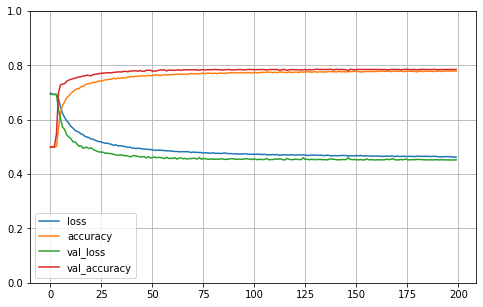

MODEL
make_DNN
input shape: (None, 84)
FIT
Epoch 1/200
2084/2084 [==============================] - 3s 1ms/step - loss: 0.7096 - accuracy: 0.5003 - val_loss: 0.6936 - val_accuracy: 0.4998
Epoch 2/200
2084/2084 [==============================] - 3s 1ms/step - loss: 0.6935 - accuracy: 0.5018 - val_loss: 0.6931 - val_accuracy: 0.4998
Epoch 3/200
2084/2084 [==============================] - 3s 1ms/step - loss: 0.6932 - accuracy: 0.5013 - val_loss: 0.6931 - val_accuracy: 0.4998
Epoch 4/200
2084/2084 [==============================] - 3s 1ms/step - loss: 0.6932 - accuracy: 0.5024 - val_loss: 0.6921 - val_accuracy: 0.5002
Epoch 5/200
2084/2084 [==============================] - 2s 1ms/step - loss: 0.6868 - accuracy: 0.5415 - val_loss: 0.6334 - val_accuracy: 0.7311
Epoch 6/200
2084/2084 [==============================] - 2s 1ms/step - loss: 0.6528 - accuracy: 0.6140 - val_loss: 0.5994 - val_accuracy: 0.7277
Epoch 7/200
2084/2084 [==============================] - 2s 1ms/step - loss: 0.6328 - a

Epoch 111/200
2084/2084 [==============================] - 3s 1ms/step - loss: 0.4710 - accuracy: 0.7756 - val_loss: 0.4502 - val_accuracy: 0.7874
Epoch 112/200
2084/2084 [==============================] - 3s 1ms/step - loss: 0.4737 - accuracy: 0.7725 - val_loss: 0.4528 - val_accuracy: 0.7873
Epoch 113/200
2084/2084 [==============================] - 3s 1ms/step - loss: 0.4718 - accuracy: 0.7748 - val_loss: 0.4503 - val_accuracy: 0.7868
Epoch 114/200
2084/2084 [==============================] - 3s 1ms/step - loss: 0.4764 - accuracy: 0.7716 - val_loss: 0.4498 - val_accuracy: 0.7871
Epoch 115/200
2084/2084 [==============================] - 3s 1ms/step - loss: 0.4747 - accuracy: 0.7717 - val_loss: 0.4512 - val_accuracy: 0.7873
Epoch 116/200
2084/2084 [==============================] - 3s 1ms/step - loss: 0.4672 - accuracy: 0.7753 - val_loss: 0.4508 - val_accuracy: 0.7868
Epoch 117/200
2084/2084 [==============================] - 3s 1ms/step - loss: 0.4730 - accuracy: 0.7723 - val_loss: 0

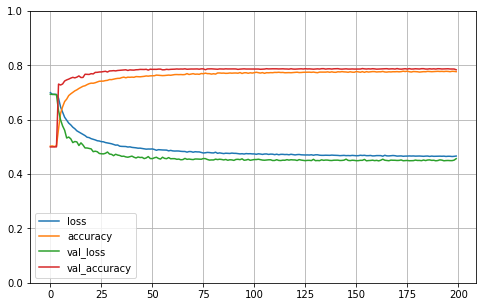

MODEL
make_DNN
input shape: (None, 84)
FIT
Epoch 1/200
2084/2084 [==============================] - 3s 1ms/step - loss: 0.7085 - accuracy: 0.4988 - val_loss: 0.6931 - val_accuracy: 0.5020
Epoch 2/200
2084/2084 [==============================] - 2s 1ms/step - loss: 0.6935 - accuracy: 0.5016 - val_loss: 0.6931 - val_accuracy: 0.5020
Epoch 3/200
2084/2084 [==============================] - 3s 1ms/step - loss: 0.6932 - accuracy: 0.5043 - val_loss: 0.6931 - val_accuracy: 0.5020
Epoch 4/200
2084/2084 [==============================] - 3s 1ms/step - loss: 0.6929 - accuracy: 0.5058 - val_loss: 0.6669 - val_accuracy: 0.5770
Epoch 5/200
2084/2084 [==============================] - 3s 1ms/step - loss: 0.6736 - accuracy: 0.5799 - val_loss: 0.6120 - val_accuracy: 0.7288
Epoch 6/200
2084/2084 [==============================] - 2s 1ms/step - loss: 0.6446 - accuracy: 0.6261 - val_loss: 0.5872 - val_accuracy: 0.7322
Epoch 7/200
2084/2084 [==============================] - 3s 1ms/step - loss: 0.6215 - a

Epoch 57/200
2084/2084 [==============================] - 3s 1ms/step - loss: 0.4851 - accuracy: 0.7677 - val_loss: 0.4573 - val_accuracy: 0.7818
Epoch 58/200
2084/2084 [==============================] - 3s 1ms/step - loss: 0.4850 - accuracy: 0.7660 - val_loss: 0.4578 - val_accuracy: 0.7825
Epoch 59/200
2084/2084 [==============================] - 3s 1ms/step - loss: 0.4880 - accuracy: 0.7652 - val_loss: 0.4570 - val_accuracy: 0.7834
Epoch 60/200
2084/2084 [==============================] - 2s 1ms/step - loss: 0.4868 - accuracy: 0.7652 - val_loss: 0.4573 - val_accuracy: 0.7837
Epoch 61/200
2084/2084 [==============================] - 2s 1ms/step - loss: 0.4854 - accuracy: 0.7661 - val_loss: 0.4566 - val_accuracy: 0.7826
Epoch 62/200
2084/2084 [==============================] - 3s 1ms/step - loss: 0.4840 - accuracy: 0.7655 - val_loss: 0.4594 - val_accuracy: 0.7824
Epoch 63/200
2084/2084 [==============================] - 3s 1ms/step - loss: 0.4869 - accuracy: 0.7646 - val_loss: 0.4537 -

2084/2084 [==============================] - 3s 1ms/step - loss: 0.4694 - accuracy: 0.7739 - val_loss: 0.4528 - val_accuracy: 0.7847
Epoch 114/200
2084/2084 [==============================] - 3s 1ms/step - loss: 0.4764 - accuracy: 0.7705 - val_loss: 0.4511 - val_accuracy: 0.7850
Epoch 115/200
2084/2084 [==============================] - 3s 1ms/step - loss: 0.4740 - accuracy: 0.7734 - val_loss: 0.4518 - val_accuracy: 0.7844
Epoch 116/200
2084/2084 [==============================] - 3s 1ms/step - loss: 0.4704 - accuracy: 0.7746 - val_loss: 0.4535 - val_accuracy: 0.7851
Epoch 117/200
2084/2084 [==============================] - 3s 1ms/step - loss: 0.4729 - accuracy: 0.7721 - val_loss: 0.4500 - val_accuracy: 0.7853
Epoch 118/200
2084/2084 [==============================] - 3s 1ms/step - loss: 0.4703 - accuracy: 0.7742 - val_loss: 0.4507 - val_accuracy: 0.7851
Epoch 119/200
2084/2084 [==============================] - 3s 1ms/step - loss: 0.4700 - accuracy: 0.7754 - val_loss: 0.4499 - val_ac

Epoch 169/200
2084/2084 [==============================] - 3s 1ms/step - loss: 0.4663 - accuracy: 0.7764 - val_loss: 0.4499 - val_accuracy: 0.7845
Epoch 170/200
2084/2084 [==============================] - 2s 1ms/step - loss: 0.4696 - accuracy: 0.7766 - val_loss: 0.4510 - val_accuracy: 0.7850
Epoch 171/200
2084/2084 [==============================] - 2s 1ms/step - loss: 0.4646 - accuracy: 0.7797 - val_loss: 0.4523 - val_accuracy: 0.7832
Epoch 172/200
2084/2084 [==============================] - 3s 1ms/step - loss: 0.4689 - accuracy: 0.7794 - val_loss: 0.4499 - val_accuracy: 0.7857
Epoch 173/200
2084/2084 [==============================] - 2s 1ms/step - loss: 0.4682 - accuracy: 0.7784 - val_loss: 0.4490 - val_accuracy: 0.7847
Epoch 174/200
2084/2084 [==============================] - 2s 1ms/step - loss: 0.4686 - accuracy: 0.7727 - val_loss: 0.4512 - val_accuracy: 0.7848
Epoch 175/200
2084/2084 [==============================] - 2s 1ms/step - loss: 0.4650 - accuracy: 0.7794 - val_loss: 0

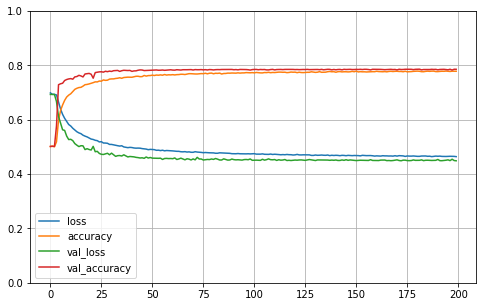

In [12]:
show_time()
last_model = do_cross_validation(X_train,y_train)
best_model = load_model(BESTMODELPATH)

In [13]:
def show_test_AUC(model,X,y):
    ns_probs = [0 for _ in range(len(y))]
    bm_probs = model.predict(X)
    ns_auc = roc_auc_score(y, ns_probs)
    bm_auc = roc_auc_score(y, bm_probs)
    ns_fpr, ns_tpr, _ = roc_curve(y, ns_probs)
    bm_fpr, bm_tpr, _ = roc_curve(y, bm_probs)
    plt.plot(ns_fpr, ns_tpr, linestyle='--', label='Guess, auc=%.4f'%ns_auc)
    plt.plot(bm_fpr, bm_tpr, marker='.', label='Model, auc=%.4f'%bm_auc)
    plt.title('ROC')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    plt.show()
    print("%s: %.2f%%" %('AUC',bm_auc*100.0))
def show_test_accuracy(model,X,y):
    scores = model.evaluate(X, y, verbose=0)
    print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))


Accuracy on training data.
2021-08-16 13:58:42 EDT


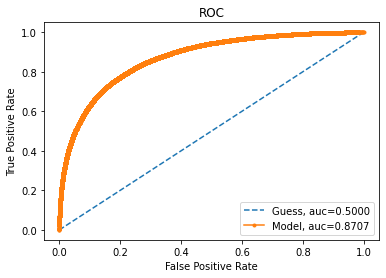

AUC: 87.07%
accuracy: 78.64%
2021-08-16 13:58:44 EDT


In [14]:
print("Accuracy on training data.")
show_time()
show_test_AUC(best_model,X_train,y_train)
show_test_accuracy(best_model,X_train,y_train)
show_time()

Accuracy on test data.
2021-08-16 13:58:44 EDT


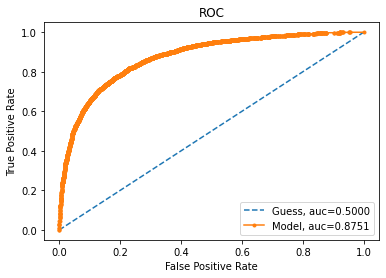

AUC: 87.51%
accuracy: 79.29%
2021-08-16 13:58:45 EDT


In [15]:
print("Accuracy on test data.")
show_time()
show_test_AUC(last_model,X_test,y_test)
show_test_accuracy(best_model,X_test,y_test)
show_time()